 ![FREYA Logo](https://github.com/datacite/pidgraph-notebooks-python/blob/master/images/freya_200x121.png?raw=true) | [FREYA](https://www.project-freya.eu/en) WP2 [User Story 1](https://github.com/datacite/freya/issues/30) | As a data center, I want to see the citations of publications that use my repository for the underlying data, so that I can demonstrate the impact of our repository. 
 :------------- | :------------- | :-------------

It is important for repositories of scientific data to monitor and report on the impact of the data they store. One useful proxy  of that impact are citations of publications accompanying the deposited data.<p />
This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to retrieve data (a.k.a. works) and their citations from three different repositories: [PANGAEA](https://www.pangaea.de/), [DRYAD](https://datadryad.org/stash) and [Global Biodiversity Information Facility](https://www.gbif.org/data-repository), using *polarstern*, *butterfly* and *Lake Malawi* as example queries respectively.

**Goal**: By the end of this notebook you should be able to: 
- Retrieve works for a chosen repository and query, along with associated metrics such as <ins>citation, view and download</ins> counts;
- Visualise the work counts over time, e.g. <br> <img src="example_plot.png" width="295" height="161" />
- Present the works in a tabular format and download them in a single BibTeX file;
- For a given work, retrieve all the citations, present them in a tabular format and then download them in a single BibTeX file.

## Install libraries and prepare GraphQL client

In [2]:
%%capture
# Install required Python packages
!pip install gql requests numpy pandas

In [3]:
# Prepare the GraphQL client
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

## Define and run the GraphQL query
Define the GraphQL to find all works from PANGAEA, DRYAD and Global Biodiversity Information Facility (GBIF) repositories using keywords: *polarstern*, *butterfly* and *Lake Malawi* respectively.

In [4]:
# Generate the GraphQL query
query_params = {
    "pangaea_repository" : "pangaea.repository",
    "pangaea_keyword" : "polarstern",
    "dryad_repository" : "dryad.dryad",
    "dryad_keyword" : "butterfly",
    "gbif_repository" : "gbif.gbif",
    "gbif_keyword" : "Lake Malawi", 
}

query = gql("""query getWorksByRepositoryAndKeyword(
    $pangaea_repository: ID!, $pangaea_keyword: String!,
    $dryad_repository: ID!, $dryad_keyword: String!
    $gbif_repository: ID!, $gbif_keyword: String!
    )
{
  pangaea: repository(id: $pangaea_repository) {
    id
    name
    citationCount
    works(query: $pangaea_keyword) {
      totalCount
      published {
        title
        count
      }
      nodes {
        id
        type
        publicationYear
        bibtex
        titles {
          title
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  },
  dryad: repository(id: $dryad_repository) {
    id
    name
    citationCount
    works(query: $dryad_keyword) {
      totalCount
      published {
        title
        count
      }
      nodes {
        id
        type
        publicationYear
        bibtex
        titles {
          title
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  },
  gbif: repository(id: $gbif_repository) {
    id
    name
    citationCount
    works(query: $gbif_keyword) {
      totalCount
      published {
        title
        count
      }
      nodes {
        id
        type
        publicationYear
        bibtex
        titles {
          title
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

Run the above query via the GraphQL client

In [5]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

## Display the number of works
For each repository, display the total number of works matching the respective query.

In [6]:
# Get the total number of datasets matching the query
works = {}
for repo in ['pangaea', 'dryad', 'gbif']:
    works[repo] = data[repo]['works']
    print("The number of works for query '%s' in repository %s:\n%s" % (query_params['%s_keyword' % repo], data[repo]['name'], str(works[repo]['totalCount'])))

The number of works for query 'polarstern' in repository PANGAEA:
19564
The number of works for query 'butterfly' in repository DRYAD:
530
The number of works for query 'Lake Malawi' in repository Global Biodiversity Information Facility:
6613


## Display the number of citations of the works
For each repository, display the total number of citations of works matching the respective query.

In [7]:
# Get the total number of citations per repository
for repo in ['pangaea', 'dryad', 'gbif']:
    print("The total number of citations for repository %s:\n%s" % (data[repo]['name'], str(data[repo]['citationCount'])))
    

The total number of citations for repository PANGAEA:
0
The total number of citations for repository DRYAD:
0
The total number of citations for repository Global Biodiversity Information Facility:
0


## Plot the number of works per year
For each repository, display a bar plot showing the counts of works matching the respective query, across years.

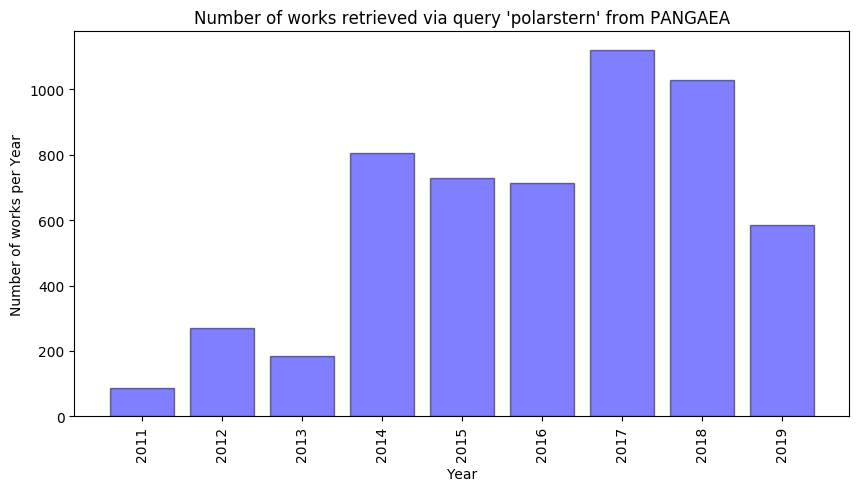

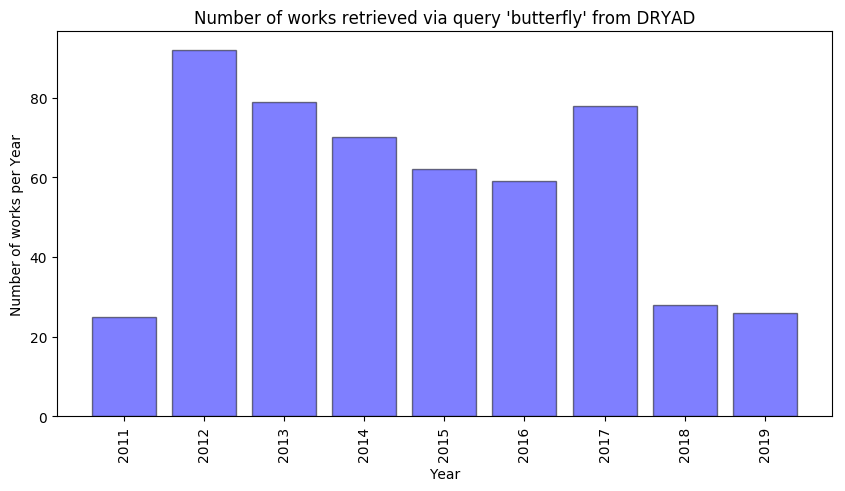

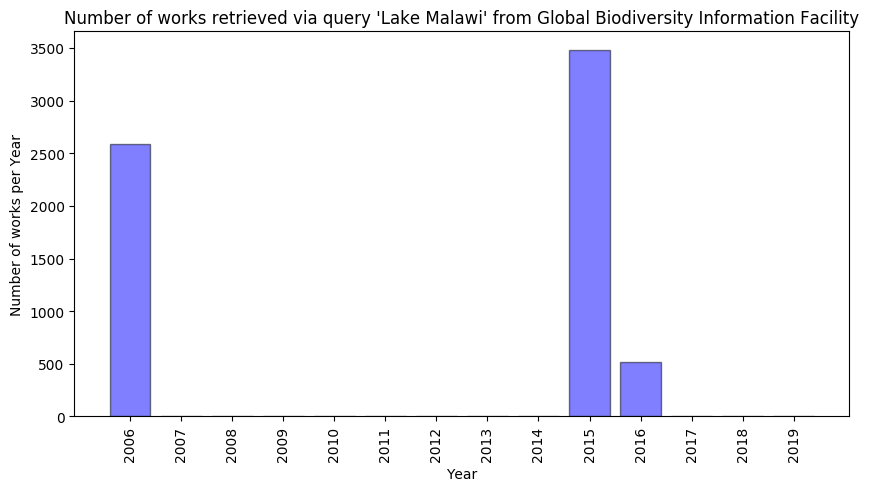

In [9]:
# Plot the total number of datasets to date, by year
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

for repo in ['pangaea', 'dryad','gbif']:
    works = data[repo]['works']
    name = data[repo]['name']
    plt.rcdefaults()
    sorted_years = sorted([int(s['title']) for s in works['published']])
    num_outputs4sorted_years = [s['count'] for s in works['published']]
    # Get a list of all consecutive years between min and max year (inclusive)
    all_years = list(range(sorted_years[0], sorted_years[-1]))
    # Populate output counts (into num_counts) for all consecutive years
    num_outputs = []
    for year in all_years:
        if year in sorted_years:
            idx = sorted_years.index(year)
            num_outputs.append(num_outputs4sorted_years[idx])
        else:
            num_outputs.append(0)     

    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    x_pos = np.arange(len(all_years))
    ax.bar(x_pos, num_outputs, align='center', color='blue', edgecolor='black', linewidth=1, alpha=0.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(all_years, rotation='vertical')
    ax.set_ylabel('Number of works per Year')
    ax.set_xlabel('Year')
    ax.set_title("Number of works retrieved via query '%s' from %s" % (query_params["%s_keyword" % repo], name))
    plt.show()


## Display works in tabular format
For each repository and query, display the works in a html table, including the number of their citations, views and downloads.

In [10]:
from IPython.core.display import display, HTML

# Get details for each output
for repo in ['pangaea', 'dryad','gbif']:
    works = data[repo]['works']
    name = data[repo]['name']
    outputs = [['ID','Type','Publication Year','Titles','Number of Citations', 'Number of Views', 'Number of Downloads']]
    for r in works['nodes']:
        id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
        titles = '; '.join([s['title'] for s in r['titles']])
        output = [id, r['type'], str(r['publicationYear']), titles, str(r['citationCount']), str(r['viewCount']), str(r['downloadCount'])]
        outputs += [output]
    
    # Display outputs as html table 
    html_table = '<html><table><caption><b>"%s" works from %s</b></caption>' % (query_params["%s_keyword" % repo], name)  
    html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
    for row in outputs[1:]:
        html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
    html_table += '</table></html>'
    display(HTML(html_table))

ID,Type,Publication Year,Titles,Number of Citations,Number of Views,Number of Downloads
10.1594/pangaea.52064,Dataset,1997,"Radionuclides and silicate measured on water bottle samples during POLARSTERN cruise ANT-X/6, supplement to: Friedrich, Jana (1997): Polonium-210 und Blei-210 im Südpolarmeer: Natürliche Tracer für biologische und hydrographische Prozesse im Oberflächenwasser des Antarktischen Zirkumpolarstroms und des Weddellmeeres (Polonium-210 and Lead-210 in the Southern Polar Ocean: Naturally occurring tracers of biological and hydrographical tracers of biological and hydrographical processes in the surface waters of the Antarctic Circumpolar Current and the Weddell Sea). Berichte zur Polarforschung = Reports on Polar Research, 235, 155 pp",0,0,0
10.1594/pangaea.54265,Dataset,1993,"Lead and aluminum in Atlantic surface water measured along the track of POLARSTERN cruise ANT-VIII/7 and ANT-IX/1 (Tables 2, 3), supplement to: Helmers, Eckard; Rutgers van der Loeff, Michiel M (1993): Lead and aluminum in Atlantic surface water (50°N to 50°S) reflecting anthropogenic and natural sources in the eolian transport. Journal of Geophysical Research: Oceans, 98(C11), 20261-20273",0,0,0
10.1594/pangaea.54605,Dataset,1997,"Organic geochemistry on surface sediments from the Laptev Sea, supplement to: Fahl, Kirsten; Stein, Ruediger (1997): Modern organic carbon deposition in the Laptev Sea and the adjacent continental slope: surface water productivity vs. terrigenous input. Organic Geochemistry, 26(5-6), 379-390",0,0,0
10.1594/pangaea.55750,Dataset,2001,"Isotope tracers (Delta δ¹³C) in Weddell Sea water during POLARSTERN cruise ANT-XII/3, supplement to: Mackensen, Andreas (2001): Oxygen and carbon stable isotope tracers of Weddell Sea water masses: new data and some paleoceanographic implications. Deep Sea Research Part I: Oceanographic Research Papers, 48(6), 1401-1422",0,0,0
10.1594/pangaea.56218,Dataset,1999,"Lipid composition of particulate matter measured on water bottle samples during POLARSTERN cruise ARK-XI/1, supplement to: Alexandrova, Olga A; Shevchenko, Vladimir P; Fahl, Kirsten; Stein, Ruediger (1999): The lipid composition of particulate matter from the transitional zone between Kara and Laptev Seas. In: Stein, R; Fahl, K; Ivanov, G I; Levitan, M A; Tarasov, G (eds.), Modern and Late Quaternary depositional environment of the St. Anna Trough area, northern Kara Sea, Reports on Polar Research, 244 pp, 342, 93-102",0,0,0
10.1594/pangaea.60056,Dataset,2007,"Radionuclides measured in surface water samples from the South Atlantic, supplement to: Hegner, Ernst; Dauelsberg, Hans-Jürgen; Rutgers van der Loeff, Michiel M; Jeandel, Catherine; de Baar, Hein J W (2007): Nd isotopes constrain the origin of suspended particles in the Atlantic sector of the Southern Ocean. Geochemistry, Geophysics, Geosystems, 8, Q10008",0,0,0
10.1594/pangaea.314690,Dataset,2003,"Effects of varying food-availability on ecology and distribution of smallest benthic organisms in sediments of the arctic Fram Strait during POLARSTERN cruise ARK-XV/2, supplement to: Schewe, Ingo; Soltwedel, Thomas (2003): Benthic response to ice-edge-induced particle flux in the Arctic Ocean. Polar Biology, 26(9), 610-620",103,0,0
10.1594/pangaea.370797,Dataset,2005,"Terrain model of the Håkon Mosby Mud Volcano (10 m grid size), supplement to: Beyer, Andreas; Rathlau, Rike; Schenke, Hans Werner (2005): Multibeam bathymetry of the Håkon Mosby Mud Volcano. Marine Geophysical Research, 26, 61-75",0,0,0
10.1594/pangaea.370808,Dataset,2006,"Terrain model of the eastern slope of the Porcupine Seabight (50 m grid size), supplement to: Beyer, Andreas; Schenke, Hans Werner; Klenke, Martin; Niederjasper, Fred (2003): High resolution bathymetry of the eastern slope of the Porcupine Seabight. Marine Geology, 198(1-2), 27-54",0,0,0
10.1594/pangaea.472287,Collection,2006,"Standard meteorological measurements on board of POLARSTERN during expedition ANT-IV (PS08, 4 cruises, south summer 

ID,Type,Publication Year,Titles,Number of Citations,Number of Views,Number of Downloads
10.5061/dryad.8bb43,Dataset,2011,Data from: UV photoreceptors and UV-yellow wing pigments in Heliconius butterflies allow a color signal to serve both mimicry and intraspecific communication,0,80,28
10.5061/dryad.8bb43/1,Dataset,2011,Reflectance spectra of Heliconiine butterfly yellow wing pigments,0,0,0
10.5061/dryad.8bb43/2,Dataset,2011,Appendix: Wing photomicrographs and averaged yellow reflectance spectra,0,0,0
10.5061/dryad.rg4dc36s,Dataset,2011,"Data from: Evidence for evolutionary change associated with the recent range expansion of the British butterfly, Polyommatus agestis, in response to climate change",0,0,0
10.5061/dryad.1705/1,Dataset,2010,Napeogenesspecies.xml,0,0,0
10.5061/dryad.1705/4,Dataset,2010,Ithomiaspecies.xml,0,0,0
10.5061/dryad.1540,Dataset,2010,Data from: Rapid microsatellite isolation from a butterfly by de novo transcriptome sequencing: performance and a comparison with AFLP-derived distances,0,157,31
10.5061/dryad.1705,Dataset,2010,Data from: Out of the Andes: patterns of diversification in clearwing butterflies,0,92,24
10.5061/dryad.1276,Dataset,2010,Data from: Allopatric origin of cryptic butterfly species that were discovered feeding on distinct host plants in sympatry,0,48,8
10.5061/dryad.615,Dataset,2009,Data from: A partitioned likelihood analysis of swallowtail butterfly phylogeny (Lepidoptera: Papilionidae),0,57,2


ID,Type,Publication Year,Titles,Number of Citations,Number of Views,Number of Downloads
10.15468/n6ftyd,Dataset,2019,rmca-albertine-rift-cichlids,81,0,0
10.15468/dl.fk6ozu,Dataset,2015,GBIF Occurrence Download,0,0,0
10.15468/dl.sdaj2e,Dataset,2015,GBIF Occurrence Download,0,0,0
10.15468/dl.pyr4ax,Dataset,2015,GBIF Occurrence Download,0,0,0
10.15468/dl.yj2she,Dataset,2015,GBIF Occurrence Download,0,0,0
10.15468/dl.t1aupt,Dataset,2015,GBIF Occurrence Download,0,0,0
10.15468/dl.iad1t6,Dataset,2015,GBIF Occurrence Download,0,0,0
10.15468/dl.fujlga,Dataset,2015,GBIF Occurrence Download,0,0,0
10.15468/dl.oqdmcc,Dataset,2015,GBIF Occurrence Download,0,0,0
10.15468/lvyqrq,Dataset,2016,Royal Museum of Central Africa - Albertian Rift Cichlids (ENBI wp13),0,0,0


## Download works in BibTeX format
Download the works in a single BibTeX file per repository

In [29]:
import pandas as pd
from IPython.display import Javascript
from requests.utils import requote_uri

# For each repository, download a file of BibTeX entries in csv format
for repo in ['pangaea', 'dryad','gbif']:
    works = data[repo]['works']
    bibtex_data = []
    for r in works['nodes']:
        bibtex_data.append([r['bibtex']])
    df = pd.DataFrame(bibtex_data, columns = None)
    
    js_download = """
var csv = '%s';

var filename = '%s_%s.bib';
var blob = new Blob([csv], { type: 'application/x-bibtex;charset=utf-8;' });
if (navigator.msSaveBlob) { // IE 10+
    navigator.msSaveBlob(blob, filename);
} else {
    var link = document.createElement("a");
    if (link.download !== undefined) { // feature detection
        // Browsers that support HTML5 download attribute
        var url = URL.createObjectURL(blob);
        link.setAttribute("href", url);
        link.setAttribute("download", filename);
        link.style.visibility = 'hidden';
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
    }
}
""" % (df.to_csv(index=False, header=False).replace('\n','\\n').replace("\'","\\'").replace("\"","").replace("\r",""), query_params["%s_repository" % repo], requote_uri(query_params["%s_keyword" % repo]))
    
    display(Javascript(js_download))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Define and run GraphQL query to retrieve citations for a single work
The query will retrieve citations for [IUCN Red List assessment occurrence data for freshwater species native to the Lake Malawi/Nyasa/Niassa Catchment](https://doi.org/10.15468/1z5fn8).

In [30]:
# Generate the GraphQL query: Get citations for a specific work from the repository
citations_query_params = {
    "id" : "https://doi.org/10.15468/1z5fn8",
    "maxCitations" : 75
}

citation_query = gql("""query getCitationsByWorkId($id: ID!, $maxCitations: Int!)
{
  work(id: $id) {
    id
    titles {
      title
    }
    type
    publicationYear
    citations(first: $maxCitations) {
      totalCount
      nodes {
        id
        type
        publicationYear
        repository {
          id
          name
        }
        titles {
          title
        }
        bibtex
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

Run the above query

In [31]:
import json
citations = client.execute(citation_query, variable_values=json.dumps(citations_query_params))

## Display the number of citations 
Display the number of citations of [IUCN Red List assessment occurrence data for freshwater species native to the Lake Malawi/Nyasa/Niassa Catchment](https://doi.org/10.15468/1z5fn8).

In [33]:
# Get the total number of citations matching the query
citations_data = citations['work']['citations']
print("The number of citations for work %s:\n%s" % (citations_query_params["id"], str(citations_data['totalCount'])))

The number of citations for work https://doi.org/10.15468/1z5fn8:
778


## Display citations in tabular format
Display citations of [IUCN Red List assessment occurrence data for freshwater species native to the Lake Malawi/Nyasa/Niassa Catchment](https://doi.org/10.15468/1z5fn8) in a html table, including the number of their respective citations, views and downloads.

In [34]:
from IPython.core.display import display, HTML

# Get details for each citation
outputs = [['ID','Type','Publication Year','Titles','Number of Citations', 'Number of Views', 'Number of Downloads']]
for r in citations_data['nodes']:
    citation_id = '<a href="%s">%s</a></html>' % (r['id'], '/'.join(r['id'].split("/")[3:]))
    titles = '; '.join([s['title'] for s in r['titles']])
    output = [citation_id, r['type'], str(r['publicationYear']), titles, str(r['citationCount']), str(r['viewCount']), str(r['downloadCount'])]
    outputs += [output]
    
# Display outputs as html table
id_href = '<a href="%s">%s</a></html>' % (citations_query_params['id'], '/'.join(citations_query_params['id'].split("/")[3:]))
html_table = '<html><table><caption><b>Citations of %s from %s</b></caption>' % (id_href, query_params["%s_repository" % "gbif"] )  
html_table += '<tr><th style="text-align:center;">' + '</th><th style="text-align:center;">'.join(outputs[0]) + '</th></tr>'
for row in outputs[1:]:
    html_table += '<tr><td style="text-align:left;">' + '</td><td style="text-align:left;">'.join(row) + '</td></tr>'
html_table += '</table></html>'
display(HTML(html_table))

ID,Type,Publication Year,Titles,Number of Citations,Number of Views,Number of Downloads
10.15468/dl.ezobqv,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.oyiynl,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.yjeevx,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.pltnoo,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.nfglle,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.2orexs,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.3c0gsw,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.qzsifz,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.8w8vv3,Dataset,2019,GBIF Occurrence Download,0,0,0
10.15468/dl.v2sxry,Dataset,2019,GBIF Occurrence Download,0,0,0


## Download citations in BibTeX format
Download the citations of [IUCN Red List assessment occurrence data for freshwater species native to the Lake Malawi/Nyasa/Niassa Catchment](https://doi.org/10.15468/1z5fn8) in a single BibTeX file.

In [35]:
import pandas as pd
from IPython.display import Javascript
from requests.utils import requote_uri

# Download a file of BibTeX entries in csv format, for the citations of citations_query_params['id']
for r in works['nodes']:
    bibtex_data = []
    for r in works['nodes']:
        bibtex_data.append([r['bibtex']])
    df = pd.DataFrame(bibtex_data, columns = None)
id_label = '/'.join(citations_query_params['id'].split("/")[3:])

js_download = """
var csv = '%s';
var filename = '%s.bib';
var blob = new Blob([csv], { type: 'application/x-bibtex;charset=utf-8;' });
if (navigator.msSaveBlob) { // IE 10+
    navigator.msSaveBlob(blob, filename);
} else {
    var link = document.createElement("a");
    if (link.download !== undefined) { // feature detection
        // Browsers that support HTML5 download attribute
        var url = URL.createObjectURL(blob);
        link.setAttribute("href", url);
        link.setAttribute("download", filename);
        link.style.visibility = 'hidden';
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
    }
}
""" % (df.to_csv(index=False, header=False).replace('\n','\\n').replace("\'","\\'").replace("\"","").replace("\r",""), requote_uri(id_label))
    
display(Javascript(js_download))

<IPython.core.display.Javascript object>